<a href="https://colab.research.google.com/github/AnnyshkaF/High-Performance-Lab/blob/main/task_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mpi4py

**(1) The number of MPI processors can be chosen arbitrarily, not depending on the picture width**

In [ ]:
%%writefile shiftedimage.py
from PIL import Image # for image loading
from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt
import tracemalloc # for memory tracing
import os
import imageio

shift_step = 40 # step to calculate pictures
duration = 5 #GIF duration
create_GIF = 0

# shift
def roll(array, shift = 0):
    return np.roll(array, shift = shift, axis=0)

tracemalloc.start() # start memory tracing

comm = MPI.COMM_WORLD
n_proc = comm.Get_size()
rank = comm.Get_rank()

data = np.array(Image.open('lion.png')).mean(axis=2) # data as loaded image
#data = np.eye(2**5, dtype=int) # data as eye matrix

if rank == 0:
    out = [] # output list of images
senddata = np.empty_like(data)

w = data.shape[1] # horizontal shape
blocks_X = w // n_proc # horizontal pointrs per process

times = [] # array for each image time
for i in range(1, data.shape[0], shift_step):
    
    start = MPI.Wtime() # start time

    add = 0
    # if last process
    if rank == n_proc-1:
        # add remainder of division
        add = w % n_proc
    
    senddata = roll(data[:, blocks_X*rank : blocks_X*(rank+1) + add], shift = i)
    senddata = comm.gather(senddata, root=0) 
    
    end = MPI.Wtime() # end time
    times.append(end-start)
    
    if rank == 0:
        # add each image into out array
        out.append(np.concatenate((senddata), axis=1))
        
if rank == 0:
    print('mean_time = ', np.mean(times)*1000,'')
    
    # memory consumption
    current, peak =  tracemalloc.get_traced_memory()
    print('current_consumption=',current,'')
    print('peak_consumption=',peak,'')
    tracemalloc.stop() # stop memory tracing
    
    # save each image
    images = []
    for i in range(len(out)):
        fname = 'tmp/AAA'+str(i * int(data.shape[0]/(2*shift_step)))+'.png'
        plt.imsave(fname, out[i], cmap='gray')
        plt.close()
        if(create_GIF == 1):
          images.append(imageio.imread(fname))
          os.remove(fname)
    if(create_GIF == 1):
      fname = 'lion_move.gif'
      imageio.mimsave(fname, images, fps = shift_step / duration)

Overwriting shiftedimage.py


In [ ]:
!mpirun -n 10 --allow-run-as-root --mca btl ^vader python3 shiftedimage.py

mean_time =  6.111540466666666 
current_consumption= 71559086 
peak_consumption= 72367963 


In [ ]:
import subprocess
times = [] # time array
memory = [] # end memory
memoryPeak = [] # peak memory
for i in range(1,10,1):
    a = subprocess.run(["mpirun","-n",str(i), "--allow-run-as-root","--mca", "btl", "^vader", "python3", "shiftedimage.py"],         
        universal_newlines=True,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE)
    res = list(a.stdout.strip().split(' '))
    times.append(res[3])
    memory.append(res[5])
    memoryPeak.append(res[7])

times = list(map(float, times))
memory = list(map(float, memory))
memoryPeak = list(map(float, memoryPeak))

**(2) Plot the speedup vs number of processors**

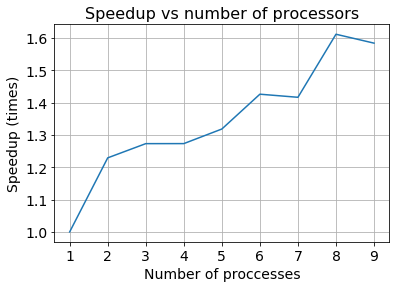

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Speedup vs number of processors', fontsize=16)
plt.plot(times[0] / np.array(times))
plt.xlabel("Number of proccesses", fontsize=14)
plt.ylabel("Speedup (times)", fontsize=14)
plt.xticks(np.arange(0, len(times)), np.arange(1, len(times)+1),  fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()

**(3) Plot memory consumption vs number of processors**

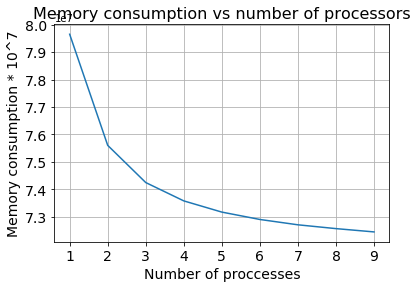

In [ ]:
plt.title('Memory consumption vs number of processors', fontsize=16)
plt.plot(np.array(memoryPeak))
plt.xlabel("Number of proccesses", fontsize=14)
plt.ylabel("Memory consumption * 10^7", fontsize=14)
plt.xticks(np.arange(0, len(memoryPeak)), np.arange(1, len(memoryPeak)+1),  fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()

In [ ]:
from IPython.display import HTML
HTML('<img src="images/task_8/lion_move.gif">')